In [1]:
import os, sys, json, pickle, itertools, numpy as np, pandas as pd, scipy.sparse as sp
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import roc_auc_score
import networkx as nx

import torch, torch.nn as nn, torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

import dgl, dgl.nn.pytorch.conv as conv

import phate, umap

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import sys
sys.path.append('..')
from gode.utils import get_device

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/ritini/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = get_device()

# seed for repeatability
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

seed = 3
torch.manual_seed(seed)
np.random.seed(seed)

In [3]:
device

'cpu'

In [4]:
data_path = "/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/alzheimer/results"

In [5]:
traj_data = np.load(f"{data_path}/microglia_subtraj_gene_space_for_ritini.npz", allow_pickle=True)

In [6]:
preds = np.load(f"{data_path}/32-granger-preds.npy")
genes = np.load(f"{data_path}/32-granger-genes.npy", allow_pickle=True)

In [7]:
adata = np.load(f"{data_path}/34-adata.npz", allow_pickle=True)

In [8]:
data = preds[0,...]

In [9]:
top_data = data
top_genes = genes

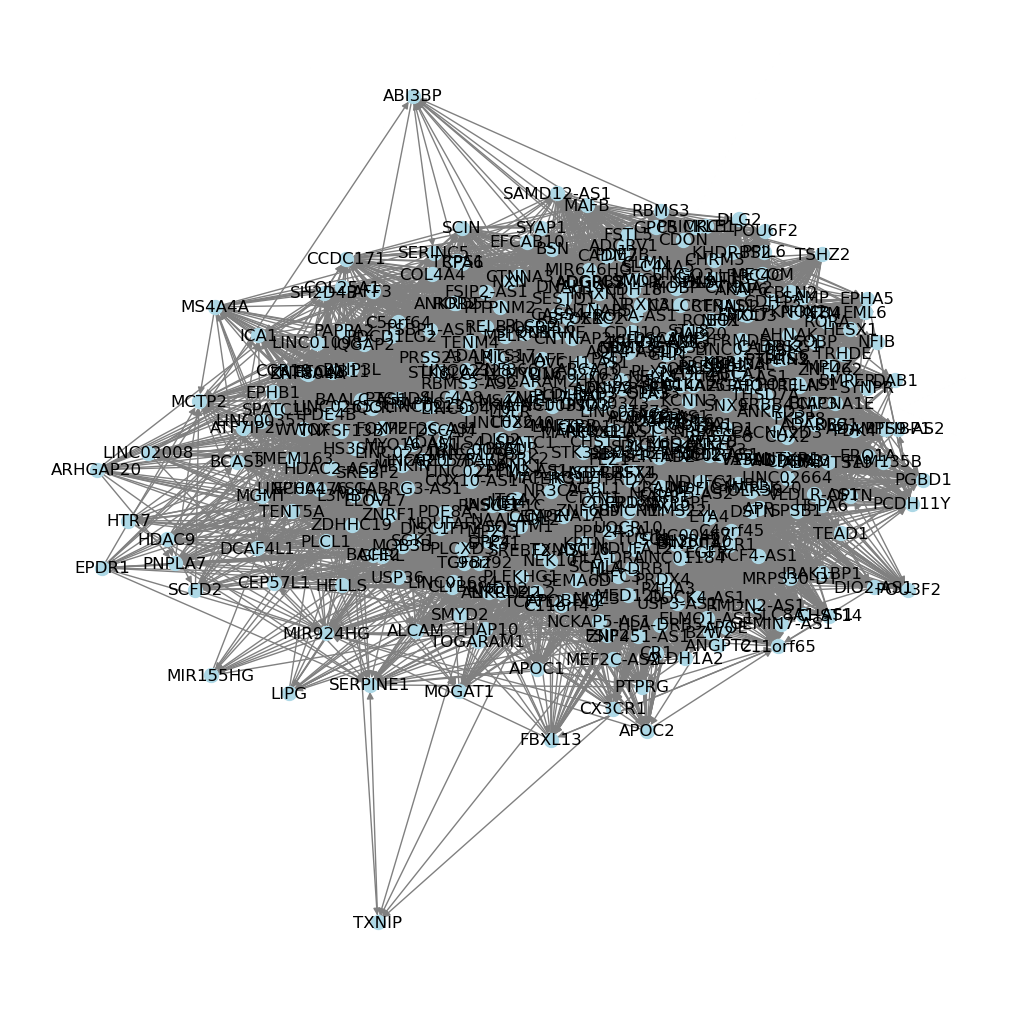

In [10]:
import networkx as nx
# Create a directed graph from the adjacency matrix
G = nx.DiGraph()

# Add nodes with labels
for i, label in enumerate(top_genes):
    G.add_node(i, label=label)

# Add edges based on the adjacency matrix
for i in range(top_data.shape[0]):
    for j in range(top_data.shape[1]):
        if top_data[i, j] >= 5.:
            G.add_edge(i, j)

# Extract node labels
# labels = nx.get_node_attributes(G, 'label')

# Draw the graph
# pos = nx.spring_layout(G.to_undirected())  # Positioning of nodes
# plt.figure(figsize=(10,10))
# nx.draw(G, pos, with_labels=True, labels=labels, node_size=100, node_color='lightblue', edge_color='gray', arrows=True)
# # nx.draw_networkx_edge_labels(G, pos, edge_labels={(i, j): top_data[i, j] for i, j in G.edges()}, font_color='red')

# plt.show()

In [11]:
edges = list(G.edges())
u, v = np.array(edges).T
u = torch.IntTensor(u)
v = torch.IntTensor(v)


g = dgl.graph((u, v))
num_edges = g.number_of_edges()

# Assign a default edge weight of 1.0 to all edges
# g.edata['weight'] = torch.ones(num_edges)

g.ndata['feat'] = torch.Tensor(np.ones((len(g.nodes()), 1)))

# g = dgl.from_networkx(G)
# g.ndata['feat'] = torch.Tensor(np.ones((len(g.nodes()), 1)))


ref_g = g.to_networkx()
ref_pos = nx.spring_layout(ref_g.to_undirected(), seed=seed)

for idx, node in enumerate(ref_g.nodes()):
    ref_g.nodes[idx]['color'] = plt.get_cmap('viridis', len(top_genes))(idx)
    ref_g.nodes[idx]['label'] = top_genes[idx]

In [12]:
# fig = plt.figure(figsize=(8, 6))
# ax = fig.add_subplot(1,1,1)

# nx.draw_networkx_labels(
#     ref_g, pos=ref_pos, ax=ax,
#     labels=nx.get_node_attributes(ref_g,'label'),
#     font_size=12, font_color='black'
# )

# nx.draw(
#     ref_g, pos=ref_pos, ax=ax,
#     with_labels=False,
#     node_color=list(nx.get_node_attributes(ref_g, 'color').values()),
#     edge_cmap=plt.cm.magma,
#     node_size=250, arrowsize=25, alpha=0.7
# )

In [13]:
# Mapping for edge ids
edge_ids = np.arange(g.number_of_edges())

# Shuffle
edge_ids = np.random.permutation(edge_ids)

test_size_percent = 30
test_size_fraction = test_size_percent / 100

edge_test_size = int(len(edge_ids) * test_size_fraction)
edge_train_size = g.number_of_edges() - edge_test_size

In [14]:
edge_test_pos_u = u[edge_ids[:edge_test_size]]
edge_test_pos_v = v[edge_ids[:edge_test_size]]

edge_train_pos_u = u[edge_ids[edge_test_size:]]
edge_train_pos_v = v[edge_ids[edge_test_size:]]

In [15]:
adjaceny_matrix = nx.adjacency_matrix(G)
adjaceny_matrix_negative = 1 - adjaceny_matrix.todense() - np.eye(g.number_of_nodes())

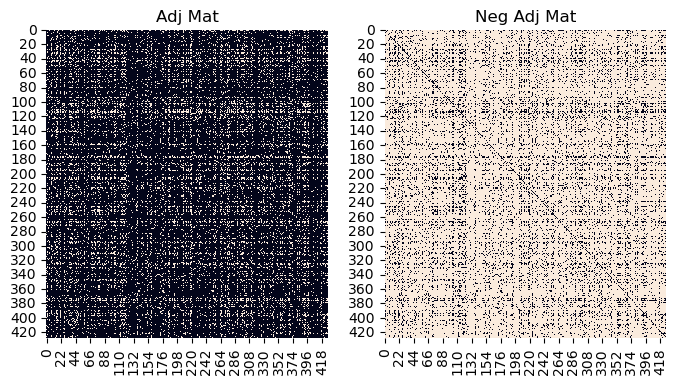

In [16]:
# fig = plt.figure(figsize=(8, 4))
# axes = fig.subplots(1, 2)

# sns.heatmap(adjaceny_matrix.todense(), label='Adj Mat', ax=axes[0], cbar=False);
# axes[0].set_title('Adj Mat');
# sns.heatmap(adjaceny_matrix_negative, label='Neg Adj Mat', ax=axes[1], cbar=False);
# axes[1].set_title('Neg Adj Mat');

In [17]:
from gode.odeblock import ODEBlock
from gode.gde import GDEFunc
from gode.dgl import DGLSAGEConv, DGLGATConv, MeanAttentionLayer

from gode.data import (
    make_mean_data_ti, make_train_test_dataframe, 
    get_data_ti, representative_cell_types_at_t,
    sample_group_index, sample_aggregate_group_at_t
)

def get_data_ti(
    df:pd.DataFrame, 
    t, 
    size:int,
    features,
    replace:bool=False,
    time_key:str='pseudotime',
    groupby:str='cell_types',
    device:torch.device=None
):
    if device is None:
        device = get_device()
        
    return torch.Tensor(
        sample_aggregate_group_at_t(
            df, t, time_key=time_key, 
            size=size, replace=replace,
            groupby=groupby, features=features
        ).values
    ).T#.to(device).T


In [18]:
def get_n_cells_of_type_k_at_time_t(df, n, k, t, genes=top_genes):
    n_genes = len(genes)
    groups = df.groupby(['cell_types', 'pseudotime'])
    if (k, t) not in groups.groups:
        values = np.array([[0 for cell in range(n)] for gene in range(n_genes)])
    else:
        values = groups.get_group((k, t))\
            .filter(genes).sample(n, replace=True)\
            .values.T
        
    # e.g. shape = (100 genes, 10 cells)
    genes_x_cells = values
    return genes_x_cells

In [19]:
gene_subset_indices = np.where(np.isin(traj_data['genes'], top_genes))[0]
np.random.seed(32)
cell_subset_indices = np.random.choice(traj_data['trajectories'].shape[1], 50, replace=False)

trajs = traj_data['trajectories']
trajs = trajs[::3]
trajs = trajs[:, cell_subset_indices]
trajs = trajs[:, :, gene_subset_indices]

In [20]:
pseudotimes = np.linspace(0, 1, trajs.shape[0])

In [44]:
traj_data['annotations']

array([0, 7, 1, 2, 5, 5, 1, 5, 5, 5, 7, 5, 0, 0, 0, 2, 7, 1, 1, 6, 0, 0,
       0, 1, 0, 0, 2, 0, 0, 1, 6, 7, 2, 1, 0, 1, 0, 2, 4, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 3, 7, 0, 7, 6, 3, 0, 0, 1, 0, 3, 0, 0, 5, 6, 0, 1, 7,
       0, 3, 0, 7, 7, 0, 0, 7, 0, 3, 0, 6, 1, 1, 7, 4, 1, 5, 0, 1, 3, 0,
       1, 3, 5, 0, 5, 6, 0, 0, 7, 1, 0, 0], dtype=int32)

In [21]:
traj_f = trajs.reshape(-1, trajs.shape[2])
annot_repeated = np.repeat(traj_data['annotations'][cell_subset_indices], trajs.shape[0])
pt_repeated = np.tile(pseudotimes, trajs.shape[1])
df = pd.DataFrame(traj_f, columns=top_genes, index=[f'cell_{i}' for i in range(traj_f.shape[0])])
df['pseudotime'] = pt_repeated
df['cell_types'] = [f'cell_type_{a}' for a in annot_repeated]

In [22]:
def get_n_cells_of_all_types_at_time_t(df, n, t, types=np.unique(df['cell_types']), genes=top_genes):
    return np.hstack(tuple([
        get_n_cells_of_type_k_at_time_t(df, n, k, t, genes=genes)
        for k in types
    ]))


In [23]:
# # import pca
# import phate
# phate_operator = phate.PHATE(t=100)
# t_phate = phate_operator.fit_transform(traj_f)

In [24]:
# import scprep
# scprep.plot.scatter2d(phate_operator.graph.data_nu, df['cell_types'])
# scprep.plot.scatter2d(phate_operator.graph.data_nu, df['pseudotime'])
# scprep.plot.scatter2d(t_phate, df['cell_types'])
# scprep.plot.scatter2d(t_phate, df['pseudotime'])

In [25]:
df_train, df_test = make_train_test_dataframe(df)

In [26]:
neg_u, neg_v = np.where(adjaceny_matrix_negative != 0)
neg_edge_ids = np.random.choice(len(neg_u), g.number_of_edges())

edge_test_neg_u = neg_u[neg_edge_ids[:edge_test_size]]
edge_test_neg_v = neg_v[neg_edge_ids[:edge_test_size]]
edge_train_neg_u = neg_u[neg_edge_ids[edge_test_size:]]
edge_train_neg_v = neg_v[neg_edge_ids[edge_test_size:]]

In [27]:
train_g = dgl.remove_edges(g, edge_ids[:edge_test_size])

train_pos_g = dgl.graph(
    (edge_train_pos_u, edge_train_pos_v), 
    num_nodes=g.number_of_nodes()
)

train_neg_g = dgl.graph(
    (edge_train_neg_u, edge_train_neg_v), 
    num_nodes=g.number_of_nodes()
)

test_pos_g = dgl.graph(
    (edge_test_pos_u, edge_test_pos_v), 
    num_nodes=g.number_of_nodes()
)

test_neg_g = dgl.graph(
    (edge_test_neg_u, edge_test_neg_v), 
    num_nodes=g.number_of_nodes()
)

In [28]:
class DGLGATConv(conv.GATConv):
    def __init__(self, graph, in_feats, out_feats, num_heads, feat_drop=0.0, attn_drop=0.0, negative_slope=0.2, residual=False, activation=None, allow_zero_in_degree=False, bias=True):
        super(DGLGATConv, self).__init__(in_feats, out_feats, num_heads, feat_drop, attn_drop, negative_slope, residual, activation, allow_zero_in_degree, bias)
        self.graph = graph

    def forward(self, feat, get_attention=False):
        return super().forward(self.graph, feat, edge_weight=None, get_attention=get_attention) # updated to address a possible api change in the latest version.

In [29]:
n_cells_at_t = df['pseudotime'].value_counts()[0]

time_bins = np.sort(df.pseudotime.unique())
cell_types = np.sort(df.cell_types.unique())

t0, *_, tn = time_bins
time_tensor = torch.Tensor(time_bins)#.to(device)

in_feats = cell_types.size * n_cells_at_t
out_feats = cell_types.size * n_cells_at_t

In [43]:
cell_types

array(['cell_type_0', 'cell_type_1', 'cell_type_2', 'cell_type_3',
       'cell_type_5', 'cell_type_6', 'cell_type_7'], dtype=object)

In [30]:
nodes_names = [top_genes[i] for i in train_g.nodes().numpy()]
node_map_full = {n:i for i, n in enumerate(nodes_names)}
# tfs = 'gene_0 gene_10 gene_20 gene_30'.split()
tfs = top_genes[::5]

In [31]:
gnn = nn.Sequential( 
    DGLGATConv(
        train_g,
        in_feats=in_feats, out_feats=out_feats, 
        num_heads=1, residual=False,
        activation=nn.Tanh(),
        feat_drop=0.0, attn_drop=0.0,
        allow_zero_in_degree=True
    ),
    MeanAttentionLayer(),
)

gdefunc = GDEFunc(gnn)
gde = ODEBlock(func=gdefunc, method='rk4', atol=1e-3, rtol=1e-4, adjoint=False).to(device)
model = gde

In [32]:
def get_edges_from_graph(g):
    u, v = g.edges()
    u = u.numpy().tolist()
    v = v.numpy().tolist()
    edges = np.vstack((u, v)).T
    return edges

def get_missing_edges_from_edges(g):
    nodes = g.nodes().numpy().tolist()
    all_edges = list(itertools.product(nodes, nodes))
    edges = get_edges_from_graph(g).tolist()  
    return list(filter(lambda e: e not in edges, map(list, all_edges)))

In [33]:
import dgl.function as fn

class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'][:, 0]
        
        
class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, 1)

    def apply_edges(self, edges):
        """
        Computes a scalar score for each edge of the given graph.

        Parameters
        ----------
        edges :
            Has three members ``src``, ``dst`` and ``data``, each of
            which is a dictionary representing the features of the
            source nodes, the destination nodes, and the edges
            themselves.

        Returns
        -------
        dict
            A dictionary of new edge features.
        """
        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']

In [34]:
pred = DotPredictor()

def compute_link_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

In [35]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.1, weight_decay=5e-4)
scheduler = StepLR(optimizer, step_size=350, gamma=0.1)
criterion = torch.nn.MSELoss()

steps = 100
verbose_step = 1

lambda_l1 = 0.5

In [36]:
# from gode.plots import custom_features_over_time
from gode.data import make_results_dataframe, get_spearmanr

In [37]:
add_n = 5
del_n = 5
link_step = 2
sample_size = 10

In [38]:
data_t0 = get_n_cells_of_all_types_at_time_t(df_train, n_cells_at_t, 0)
# data_t1 = get_n_cells_of_all_types_at_time_t(df_train, n_cells_at_t, _t + 1) 

In [39]:
num_cell_types = len(df['cell_types'].unique())
num_genes = len(top_genes)

In [42]:
data_t0.shape

(428, 350)

In [41]:
df_train

,SPSB1,MARCKSL1,DAB1,PDE4B,SLC44A5,ADGRL2,TXNIP,KCNN3,ADAMTS4,HSPA6,...,UQCR10,MAFF,SREBF2-AS1,SREBF2,SYAP1,PRDX4,PCDH11X,PCDH11Y,pseudotime,cell_types
cell_948,0.043346,0.008224,0.499847,1.064916,0.078298,0.211244,0.587767,0.017032,0.005391,0.147134,...,0.080819,0.008858,0.003916,0.544199,0.180218,0.072156,0.079308,0.040114,0.909091,cell_type_0
cell_1404,0.042846,0.006796,0.523054,1.245983,0.090433,0.272137,0.683784,0.036101,0.007800,0.158903,...,0.054208,0.013449,0.008868,0.601294,0.212823,0.042415,0.049841,0.011384,0.303030,cell_type_7
cell_343,0.027627,0.036540,0.600662,1.172698,0.209236,0.457707,0.293724,0.066854,0.019901,0.146222,...,0.103171,0.000376,0.003109,0.295672,0.123063,0.037397,0.134676,0.095532,0.090909,cell_type_0
cell_310,0.064776,0.018488,0.415674,1.060272,0.084485,0.211742,0.321216,0.026007,0.035073,0.110490,...,0.102873,0.004175,0.010520,0.530395,0.119964,0.040905,0.064716,0.051518,0.121212,cell_type_7
cell_659,0.045830,0.003031,0.476470,1.361900,0.070630,0.197605,0.574444,0.003523,0.010607,0.181814,...,0.093320,0.007564,0.012773,0.316202,0.185412,0.066694,0.075297,0.029700,0.393939,cell_type_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cell_769,0.020324,0.024425,0.568190,1.270173,0.163125,0.373966,0.207990,0.026384,0.010524,0.078693,...,0.033706,0.004816,0.008103,0.360665,0.115082,0.037912,0.102084,0.054822,0.636364,cell_type_5
cell_1164,0.057713,0.026447,0.678207,1.261214,0.191298,0.392084,0.536723,0.038384,0.003588,0.140538,...,0.178670,0.013587,0.015033,0.407086,0.190062,0.071504,0.119266,0.083979,0.242424,cell_type_7
cell_724,0.020452,0.017902,0.523269,1.283884,0.145833,0.347945,0.248522,0.020436,0.009263,0.103160,...,0.035112,0.009268,0.007266,0.314444,0.116872,0.051193,0.099120,0.050202,0.303030,cell_type_5
cell_478,0.070778,0.007599,0.536791,1.016047,0.166169,0.310598,0.328360,0.036553,0.014414,0.140771,...,0.101013,0.033530,0.011309,0.499790,0.134538,0.073388,0.094082,0.066618,0.060606,cell_type_3


In [ ]:
device = 'cpu'
DATA_DIR = './'
model = model.to(device)
attentions = {}

for step_i in range(steps):   
    
    data_tps = []
    data_tis = []
    for _t, time_i in enumerate(time_bins[:-1]):    
        
#         data_t0 = get_data_ti(df_train, _t, sample_size, df_data.columns, replace=True)
#         data_t1 = get_data_ti(df_train, _t+1, sample_size, df_data.columns, replace=True)
        
        data_t0 = get_n_cells_of_all_types_at_time_t(df_train, n_cells_at_t, _t)
        data_t1 = get_n_cells_of_all_types_at_time_t(df_train, n_cells_at_t, _t + 1)        
        data_t0 = torch.Tensor(data_t0)#.to(device)
        data_t1 = torch.Tensor(data_t1)#.to(device)
        
        t0 = time_bins[_t]
        t1 = time_bins[_t + 1]
        
        model.train()        
        data_tp = model(
            data_t0,  
            torch.Tensor([t0, t1]),#.to(device), 
            return_whole_sequence=False
        )    
                
        pos_score = pred(train_pos_g, data_tp)
        neg_score = pred(train_neg_g, data_tp)
        link_loss = compute_link_loss(pos_score, neg_score)
        
        _, attn = model.func.gnn[0](data_t0, get_attention=True)
    
        loss = criterion(data_tp, data_t1) + 10 * link_loss # + lambda_l1 * torch.norm(attn, 1)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if _t == 0:
            data_tis.append(data_t0.clone().detach())
        data_tis.append(data_t1.clone().detach())
        data_tps.append(data_tp.clone().detach())
        
    
    if step_i % link_step == 0:
        model.eval()
        with torch.no_grad():
            # HANDLE LINKS
            # Find edges to add
            missing_edges = np.array(get_missing_edges_from_edges(train_g)).T
            missing_u, missing_v = missing_edges

            missing_g = dgl.graph(
                (torch.IntTensor(missing_u), torch.IntTensor(missing_v)), 
                num_nodes=g.number_of_nodes()
            )

            missing_score = pred(missing_g, data_tp)
            missing_idxs = np.argsort(missing_score.numpy())

            best_u = missing_u[missing_idxs[-add_n:]]
            best_v = missing_v[missing_idxs[-add_n:]]


            # Find edges to remove
            current_u, current_v = get_edges_from_graph(train_g).T

            current_scores = pred(train_g, data_tp)
            current_idxs = np.argsort(current_scores.numpy())

            worst_u = current_u[current_idxs[:del_n]]
            worst_v = current_v[current_idxs[:del_n]]

            to_remove = train_g.edge_ids(torch.IntTensor(worst_u), torch.IntTensor(worst_v))
    
            train_g.remove_edges(to_remove)
            train_g.add_edges(torch.IntTensor(best_u), torch.IntTensor(best_v))

        

        
        
        
    scheduler.step()   
    
    if step_i % verbose_step == 0:
        model.eval()
        with torch.no_grad():
            
#         data_t0 = get_data_ti(df_train, _t, sample_size, df_data.columns, replace=True)
#         data_t1 = get_data_ti(df_train, _t+1, sample_size, df_data.columns, replace=True)
        
            data_t0 = get_n_cells_of_all_types_at_time_t(df_train, n_cells_at_t, _t)
            data_t1 = get_n_cells_of_all_types_at_time_t(df_train, n_cells_at_t, _t + 1)        
            data_t0 = torch.Tensor(data_t0)#.to(device)
            data_t1 = torch.Tensor(data_t1)#.to(device)
        
            data_tp = model(data_t0,  time_tensor, return_whole_sequence=True)

        
            pos_score = pred(test_pos_g, data_tp[-1])
            neg_score = pred(test_neg_g, data_tp[-1])
            auc_score = compute_auc(pos_score, neg_score)
            print('[{}],\t Loss: {:3.5f},\t AUC: {:3.5f}'.format(step_i + 1, loss, auc_score)) 


                
        
            attns = np.empty(0)
            data_tp = data_tps
            data_tps = []
            data_tis = []
            for _t, time_i in enumerate(time_bins[:-1]): 
#         data_t0 = get_data_ti(df_train, _t, sample_size, df_data.columns, replace=True)
#         data_t1 = get_data_ti(df_train, _t+1, sample_size, df_data.columns, replace=True)

                data_t0 = get_n_cells_of_all_types_at_time_t(df_train, n_cells_at_t, _t)
                data_t1 = get_n_cells_of_all_types_at_time_t(df_train, n_cells_at_t, _t + 1)        
                data_t0 = torch.Tensor(data_t0)#.to(device)
                data_t1 = torch.Tensor(data_t1)#.to(device)

                t0 = time_bins[_t]
                t1 = time_bins[_t + 1]

                data_tp = model(
                    data_t0,  
                    torch.Tensor([t0, t1]),#.to(device), 
                    return_whole_sequence=False
                )    




                if _t == 0:
                    data_tis.append(data_t0.clone().detach())
                data_tis.append(data_t1.clone().detach())
                data_tps.append(data_tp.clone().detach())

                _, attn = model.func.gnn[0](data_t0, get_attention=True)

                attn = attn.reshape(-1).detach().cpu().numpy()        
                attns = np.vstack((attns, attn)) if attns.size else attn

            attns = np.array(attns)
            
            if step_i in np.arange(0, steps, 10):#[0, int(steps/2), steps-1]:
                data_ti = torch.Tensor(np.array([t.detach().cpu().numpy() for t in data_tis]))
                data_tp = torch.Tensor(np.array([t.detach().cpu().numpy() for t in data_tps]))
                
                dti = data_ti.detach().numpy()
                dtp = data_tp.detach().numpy()
                
                idx = np.arange(num_cell_types) * n_cells_at_t - 1
                idx[0] = 0
                
                dti_t = torch.Tensor(dti[:, :, idx])
                dtp_t = torch.Tensor(dtp[:, :, idx])
                
                # df_res = make_results_dataframe(
                #     dti_t, dtp_t, 
                #     nodes_names, cell_types, tfs
                # )
                
                # df_corr = get_spearmanr(dti_t, dtp_t, columns=cell_types, index=node_map_full)
                
                # fig = custom_features_over_time(
                #     df_res, df_corr,
                #     col='tf', row='cell_type',
                #     hue='type', x='time', y='expression'
                # )            
                # fig.savefig(os.path.join(DATA_DIR, f'{n_cells_at_t}_cells_expression_epoch_{step_i}.png'))
                
                
                # nx_g = train_g.to_networkx()

                # fig = plt.figure(figsize=(8, 6))
                # ax = fig.add_subplot(1,1,1)

                # nx.draw_networkx_labels(
                #     nx_g, pos=ref_pos, ax=ax,
                #     labels=nx.get_node_attributes(ref_g,'label'),
                #     font_size=12, font_color='black'
                # )

                # nx.draw(
                #     nx_g, pos=ref_pos, ax=ax,
                #     with_labels=False,
                #     node_color=list(nx.get_node_attributes(ref_g, 'color').values()),
                #     edge_cmap=plt.cm.magma,
                #     node_size=500, arrowsize=25, alpha=0.7
                # )
                
                # fig.savefig(os.path.join(DATA_DIR, f'{n_cells_at_t}_cells_graph_epoch_{step_i}.png'))
                
                attentions[step_i] = np.array(attns)
                
                
            data_tp = np.array([t.detach().cpu().numpy() for t in data_tps])

In [ ]:
data_ti = torch.Tensor(np.array([t.detach().cpu().numpy() for t in data_tis]))
data_tp = torch.Tensor(np.array([t.detach().cpu().numpy() for t in data_tps]))

dti = data_ti.detach().numpy()
dtp = data_tp.detach().numpy()

idx = np.arange(num_cell_types) * n_cells_at_t - 1
idx[0] = 0
idx

torch.save(data_ti, 'data_ti.pt')
torch.save(data_tp, 'data_tp.pt')

In [ ]:
# Move model to CPU before saving to avoid CUDA issues
model_cpu = model.cpu()
torch.save(model_cpu.state_dict(), 'model_state_dict.pt')
# If you need to save the entire model structure as well, use:
torch.save(model_cpu, 'model_full.pt')
# Move model back to original device if needed
model = model.to(device)

In [ ]:
dti_t = torch.Tensor(dti[:, :, idx])
dtp_t = torch.Tensor(dtp[:, :, idx])

In [ ]:
df_res = make_results_dataframe(
    dti_t, dtp_t, 
    nodes_names, cell_types, tfs
)


In [ ]:
df_corr = get_spearmanr(dti_t, dtp_t, columns=cell_types, index=node_map_full)

In [ ]:
df_res.to_csv('df_res.csv')
df_corr.to_csv('df_corr.csv')
# fig = custom_features_over_time(

In [ ]:
# fig = custom_features_over_time(
#     df_res, df_corr,
#     col='tf', row='cell_type',
#     hue='type', x='time', y='expression'
# )            

In [ ]:
nx_g = train_g.to_networkx()
# pos = nx.kamada_kawai_layout(nx_g, scale=1, dim=2)
import pickle
with open('graph.pkl', 'wb') as f:
    pickle.dump(nx_g, f)

In [ ]:
# nx_g = train_g.to_networkx()

# fig = plt.figure(figsize=(8, 6))
# ax = fig.add_subplot(1,1,1)

# nx.draw_networkx_labels(
#     nx_g, pos=ref_pos, ax=ax,
#     labels=nx.get_node_attributes(ref_g,'label'),
#     font_size=12, font_color='black'
# )

# nx.draw(
#     nx_g, pos=ref_pos, ax=ax,
#     with_labels=False,
#     node_color=list(nx.get_node_attributes(ref_g, 'color').values()),
#     edge_cmap=plt.cm.magma,
#     node_size=500, arrowsize=25, alpha=0.7
# )

In [ ]:
# train_g.remove_edges(train_g.edge_ids(train_g.edges()[0][:100], train_g.edges()[1][:100]))

In [ ]:
# len(train_g.edges()[0])

In [ ]:
# nx_g = train_g.remove_self_loop().to_networkx()

# fig = plt.figure(figsize=(18, 18))
# ax = fig.add_subplot(1,1,1)

# nx.draw_networkx_labels(
#     nx_g, pos=ref_pos, ax=ax,
#     labels=nx.get_node_attributes(ref_g,'label'),
#     font_size=12, font_color='black'
# )

# nx.draw(
#     nx_g, pos=ref_pos, ax=ax,
#     with_labels=False,
#     # node_color=list(nx.get_node_attributes(ref_g, 'color').values()),
#     node_color='lightblue', edge_color='gray',
#     # edge_cmap=plt.cm.magma,
#     node_size=500, arrowsize=25, alpha=0.7
# )

In [ ]:
# fig = plt.figure(figsize=(18, 18))
# ax = fig.add_subplot(1,1,1)

# nx.draw_networkx_labels(
#     ref_g, pos=ref_pos, ax=ax,
#     labels=nx.get_node_attributes(ref_g,'label'),
#     font_size=12, font_color='black'
# )

# nx.draw(
#     ref_g, pos=ref_pos, ax=ax,
#     with_labels=False,
#     # node_color=list(nx.get_node_attributes(ref_g, 'color').values()),
#     node_color='lightblue', edge_color='gray',
#     # edge_cmap=plt.cm.magma,
#     node_size=250, arrowsize=25, alpha=0.7
# )

In [ ]:
# import pickle
# with open('graph.pkl', 'wb') as f:
#     pickle.dump(nx_g, f)

In [ ]:
# adj_matrix = nx.to_numpy_array(nx_g)

# n_bins = 100  # Number of bins for interpolation

# plt.figure(figsize=(20, 18))  
# plt.imshow(adj_matrix, cmap='binary')
# plt.xticks(ticks=np.arange(len(top_genes)), labels=top_genes, rotation=90)
# plt.yticks(ticks=np.arange(len(top_genes)), labels=top_genes)

# cbar = plt.colorbar(label='Values', fraction=0.046, pad=0.04, shrink=0.8)
# cbar.ax.tick_params(labelsize=20)
# cbar.set_label('Values', fontsize=20)
# plt.title('GRN inferred from trajectories with Granger Causality', fontsize=20)
# plt.show()